In [1]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, Add
from tensorflow.keras.layers import LeakyReLU, ReLU

Using TensorFlow backend.


In [3]:
MODEL_DIR = "../assets/models/"
DATA_DIR = "../assets/data/"
LABELS_FILE = os.path.join(DATA_DIR, "labels.txt")
IMAGES_DIR = os.path.join(DATA_DIR, "samples")

(455, 320, 3)


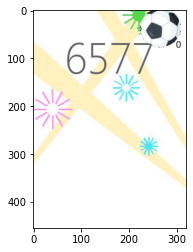

In [4]:
im = cv2.imread(os.path.join(IMAGES_DIR, "sample_0.JPEG"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)
plt.imshow(im)

SRC_HEIGHT, SRC_WIDTH, SRC_DEPTH = im.shape

In [5]:
# model_name = "cnn_113_80.h5f"
# large = False

model_name = "cnn_227_160.h5f"
large = True

import re
p = re.compile(r"cnn_(\d+)_(\d+).h5f")
h, w = p.findall(model_name)[0]
h, w = int(h), int(w)

TARGET_SIZE = (h, w)

# ZOOM_FACTOR = 2
# TARGET_SIZE = (SRC_HEIGHT//ZOOM_FACTOR, SRC_WIDTH//ZOOM_FACTOR)

print(f"target_size = {TARGET_SIZE}")

OUTPUT_SHAPE = 3
BATCH_SIZE = 128

target_size = (227, 160)


In [6]:
record_filenames = sorted(tf.io.gfile.glob('../assets/data/records/images-*.tfrec'))[:20]
N = len(record_filenames)
ratio = 0.15

n_train = int((1-ratio)*N)
n_test = N-n_train

train_filenames = record_filenames[:n_train]
test_filenames = record_filenames[n_train:]

In [7]:
AUTO = tf.data.experimental.AUTOTUNE

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize(image, TARGET_SIZE)
    image = tf.reverse(image, axis=[-1])
    #image = tf.reshape(image, [*TARGET_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string), 
        "x_center": tf.io.FixedLenFeature([], tf.float32),  
        "y_center": tf.io.FixedLenFeature([], tf.float32),  
        "confidence": tf.io.FixedLenFeature([], tf.float32),  
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = (example['x_center'], example['y_center'], example['confidence'])
    label = [tf.cast(x, tf.float32) for x in label]
    return image, label


def read_dataset(filenames):
    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 

    opt = tf.data.Options()
    opt.experimental_deterministic = False
    dataset = dataset.with_options(opt) 

    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    
    return dataset

def data_augment(image, label):
    #image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label 

def get_train_dataset(filenames):
    d = read_dataset(filenames)
#     d = d.map(data_augment, num_parallel_calls=AUTO)
    d = d.repeat()
    d = d.shuffle(2048)
    d = d.batch(BATCH_SIZE)
    d = d.prefetch(AUTO)
    return d

def get_test_dataset(filenames):
    d = read_dataset(filenames)
    d = d.batch(BATCH_SIZE)
    d = d.cache()
    d = d.prefetch(AUTO)
    return d

In [8]:
train_dataset = get_train_dataset(train_filenames)
test_dataset = get_test_dataset(test_filenames)

tf.Tensor([0.7296875 0.3021978 1.       ], shape=(3,), dtype=float32)


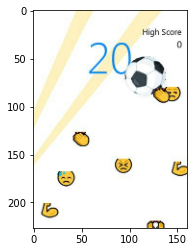

In [10]:
# for images, labels in train_dataset.take(1):
#     break
for i, (image, label) in enumerate(zip(images, labels)):
    print(label)
    plt.imshow(image)
    plt.show()
    break

In [11]:
def detect_accuracy(y_true, y_pred, thresh=0.8):
    true_cls = y_true[:,2]
    pred_cls = y_pred[:,2]
    pred_cls = tf.math.greater(pred_cls, thresh)
    pred_cls = tf.cast(pred_cls, true_cls.dtype)
    
    abs_err = tf.math.abs(true_cls-pred_cls)
    return 1-tf.math.reduce_mean(abs_err)

def position_accuracy(y_true, y_pred):
    true_cls = y_true[:,2]
    true_pos = y_true[:,:2]
    pred_pos = y_pred[:,:2]
    
    abs_err = tf.math.abs(true_pos-pred_pos)
    dist_sqr_err = tf.math.reduce_sum(tf.math.square(abs_err), axis=1)
    dist_err = tf.math.sqrt(dist_sqr_err)
    
    # only consider when object is there
    dist_err = tf.math.multiply(dist_err, true_cls)
    net_err = tf.math.reduce_sum(dist_err)
    total_objects = tf.math.reduce_sum(true_cls)
    
    mean_err = net_err / total_objects
    return 1-mean_err

In [12]:
def create_model(large=False):
    alpha = 0.2
    dropout = 0.1

    inputs = Input(shape=TARGET_SIZE+(3,))

#    x_skip = inputs
    
    x = Conv2D(16, (3, 3))(inputs)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(64, (3, 3))(x)
    x = ReLU()(x)
    
    if large:
        x = MaxPooling2D((2, 2))(x)
    else:
        x = MaxPooling2D((3, 3))(x)
    
#     x_skip = Conv2D(64, (16, 16))(x_skip)
#     x_skip = MaxPooling2D((17,17))(x_skip)
#     x = Add()([x, x_skip])

    # larger network
    if large:
        x = Conv2D(64, (3, 3))(x)
        x = ReLU()(x)
        x = MaxPooling2D((2, 2))(x)

        x = SeparableConv2D(128, (3, 3), padding="same")(x)
        x = ReLU()(x)
        x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)

    if large:
        x = Dense(128)(x)
        x = ReLU()(x)
    
    x = Dense(64)(x)
    x = ReLU()(x)

    x = Dense(32)(x)
    x = ReLU()(x)

    x = Dense(OUTPUT_SHAPE)(x)
    outputs = x
    #outputs = LeakyReLU(alpha)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model(large=large)

model.load_weights(os.path.join(MODEL_DIR, model_name))
#model.load_weights(os.path.join(MODEL_DIR, "cnn_227_160.h5f"))

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss="mae",
    metrics=[detect_accuracy, position_accuracy],
)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 225, 158, 16)      448       
_________________________________________________________________
re_lu (ReLU)                 (None, 225, 158, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 79, 16)       0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 110, 77, 32)       688       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 110, 77, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 38, 32)        0     

In [13]:
record_size = 1000
n_train = len(train_filenames)*record_size
n_test = len(test_filenames)*record_size

steps_per_epoch = n_train // BATCH_SIZE
validation_steps = n_test // BATCH_SIZE

print("steps per epoch: {0}".format(steps_per_epoch))
print("validation steps {0}".format(validation_steps))

TOTAL_EPOCHS = 10

model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    epochs=TOTAL_EPOCHS,
    validation_data=test_dataset)

steps per epoch: 132
validation steps 23
Train for 132 steps
Epoch 1/10
132/132 [==============================] - 51s 389ms/step - loss: 0.0069 - detect_accuracy: 0.9993 - position_accuracy: 0.9791 - val_loss: 0.0067 - val_detect_accuracy: 0.9987 - val_position_accuracy: 0.9798
Epoch 2/10
132/132 [==============================] - 37s 280ms/step - loss: 0.0061 - detect_accuracy: 0.9998 - position_accuracy: 0.9819 - val_loss: 0.0063 - val_detect_accuracy: 0.9987 - val_position_accuracy: 0.9801
Epoch 3/10
132/132 [==============================] - 46s 346ms/step - loss: 0.0059 - detect_accuracy: 0.9999 - position_accuracy: 0.9831 - val_loss: 0.0075 - val_detect_accuracy: 0.9987 - val_position_accuracy: 0.9773
Epoch 4/10
132/132 [==============================] - 36s 274ms/step - loss: 0.0052 - detect_accuracy: 0.9999 - position_accuracy: 0.9842 - val_loss: 0.0064 - val_detect_accuracy: 0.9987 - val_position_accuracy: 0.9780
Epoch 5/10
132/132 [==============================] - 37s 277ms

In [14]:
model.save_weights(os.path.join(MODEL_DIR, model_name))
# model.save_weights("../models/cnn_227_160.h5f")
# model.save_weights("../models/cnn_113_80.h5f")

In [15]:
y_pred = model.predict(images)
y_true = labels
print(detect_accuracy(y_pred, y_true))
print(position_accuracy(y_pred, y_true))

tf.Tensor(0.9969693, shape=(), dtype=float32)
tf.Tensor(0.9877982, shape=(), dtype=float32)
